In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [2]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation

In [3]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        #print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2])
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate):
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            #grad = np.abs(elem[:,3] / (elem[:,2] + 1e-6))
            sx = -1#-1*np.sign(elem[:, 3]) * w * 1/np.sqrt(1+grad**2)
            sy = -1#np.sign(elem[:, 2]) * w * grad * 1/np.sqrt(1+grad**2)
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            #debug_min_x = min(pr["x"])
            #debug_max_x = max(pr["x"])
            #debug_min_y = min(pr["y"])
            #debug_max_y = max(pr["y"])
            #if debug_min_x < 1130 and debug_max_y < 1590:
                #print(f"debug_min_x = {debug_min_x} debug_max_x = {debug_max_x} debug_min_y = {debug_min_y} debug_max_y = {debug_max_y}")
                #print(f"sx = {sx[0]} sy = {sy[0]}")
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            xmin = np.min(lane["x"]) if lane["fx"] else np.min(lane["y"])
            xmax = np.max(lane["x"]) if lane["fx"] else np.max(lane["y"])
            prior_list.append({"c": (a0,a1,a2), "xmin": xmin, "xmax": xmax, "fx": lane["fx"]})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

scene_id=365 scene_name=scene-0451 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/365/database
frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 0
Number of extended tracks before run() 0
frame_idx = 1
Number of new plots 0
Number of dynamic tracks before run() 0
frame 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


Number of point tracks before run() 29
Number of extended tracks before run() 0
frame_idx = 2
Number of new plots 0
Number of dynamic tracks before run() 0
frame 2


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Number of point tracks before run() 59
Number of extended tracks before run() 0
frame_idx = 3
Number of new plots 0
Number of dynamic tracks before run() 0
frame 3
Number of point tracks before run() 70
Number of extended tracks before run() 0
frame_idx = 4
Number of new plots 0
Number of dynamic tracks before run() 0
frame 4
Number of point tracks before run() 87
Number of extended tracks before run() 0
frame_idx = 5
Number of new plots 0
Number of dynamic tracks before run() 0
frame 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 97
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.09368328e+01 -2.90051330e-01 -4.95512461e-03  2.01717163e+01
  3.97403071e+01]
delete_indices [9, 14, 15, 16, 41, 43, 44, 47, 62, 90, 92, 97, 111]
frame_idx = 6
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [28.54228904 -1.74771431  0.0435915   9.56229515 19.2941168 ]
delete_indices [0, 1, 2, 28, 29, 61, 78, 79, 99, 116]
frame_idx = 7
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 8
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 9
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.041496311557852765, -1.662790936828064, 28.29730155544915) (0.032449444706979906, -1.5201404683555444, 30.04748196473281)
Tracks are similar! do not open a new trk (0.041496311557852765, -1.662790936828064, 28.29730155544915) (0.051251513250537936, -2.0707887462212757, 31.8413297575753)
frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


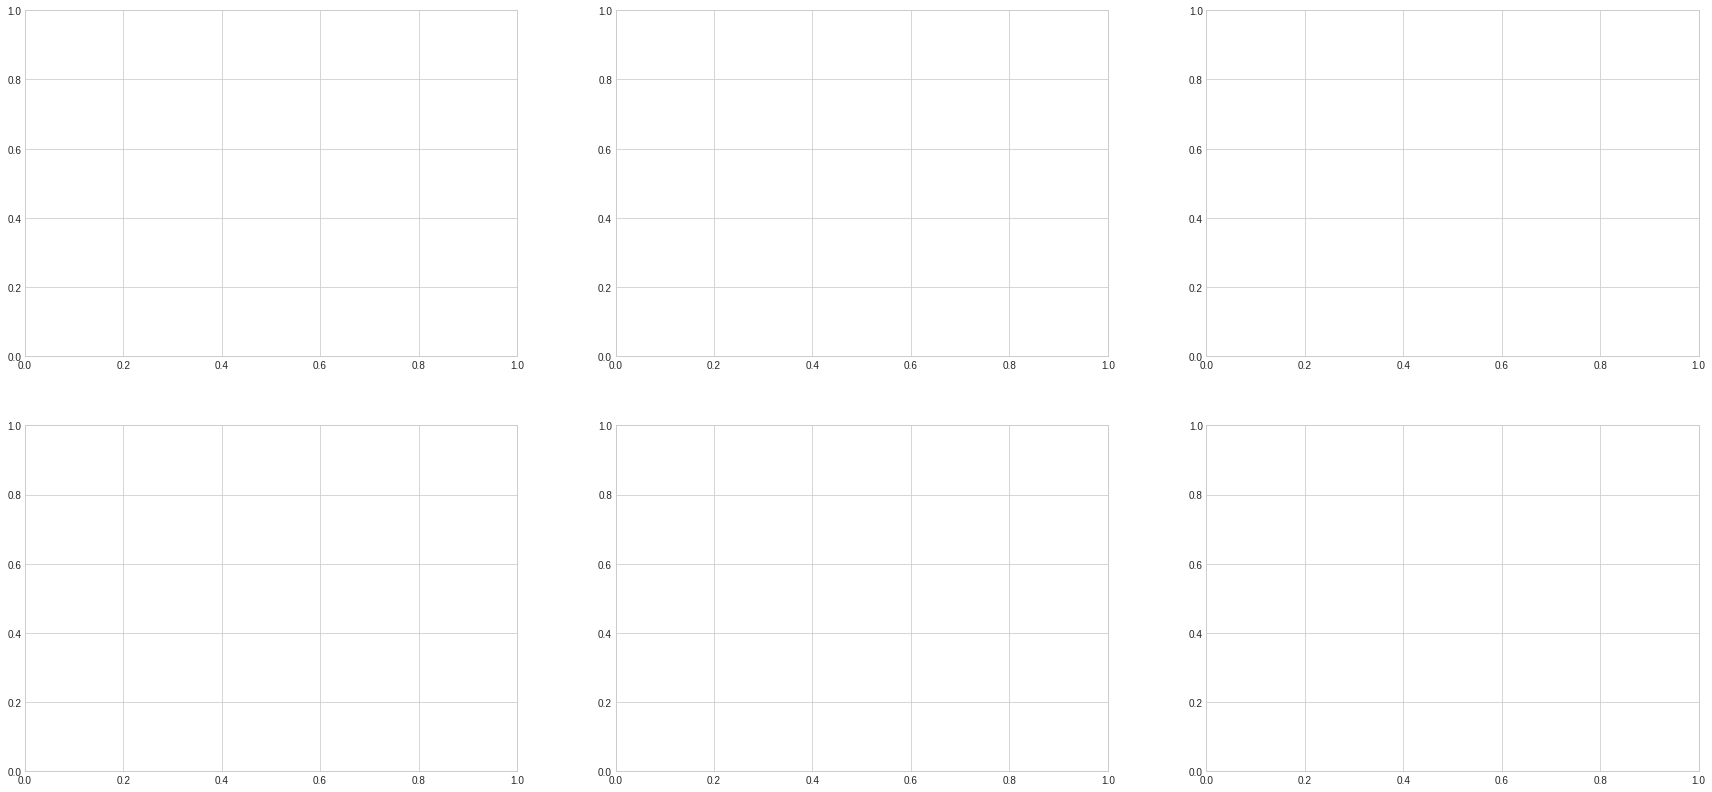

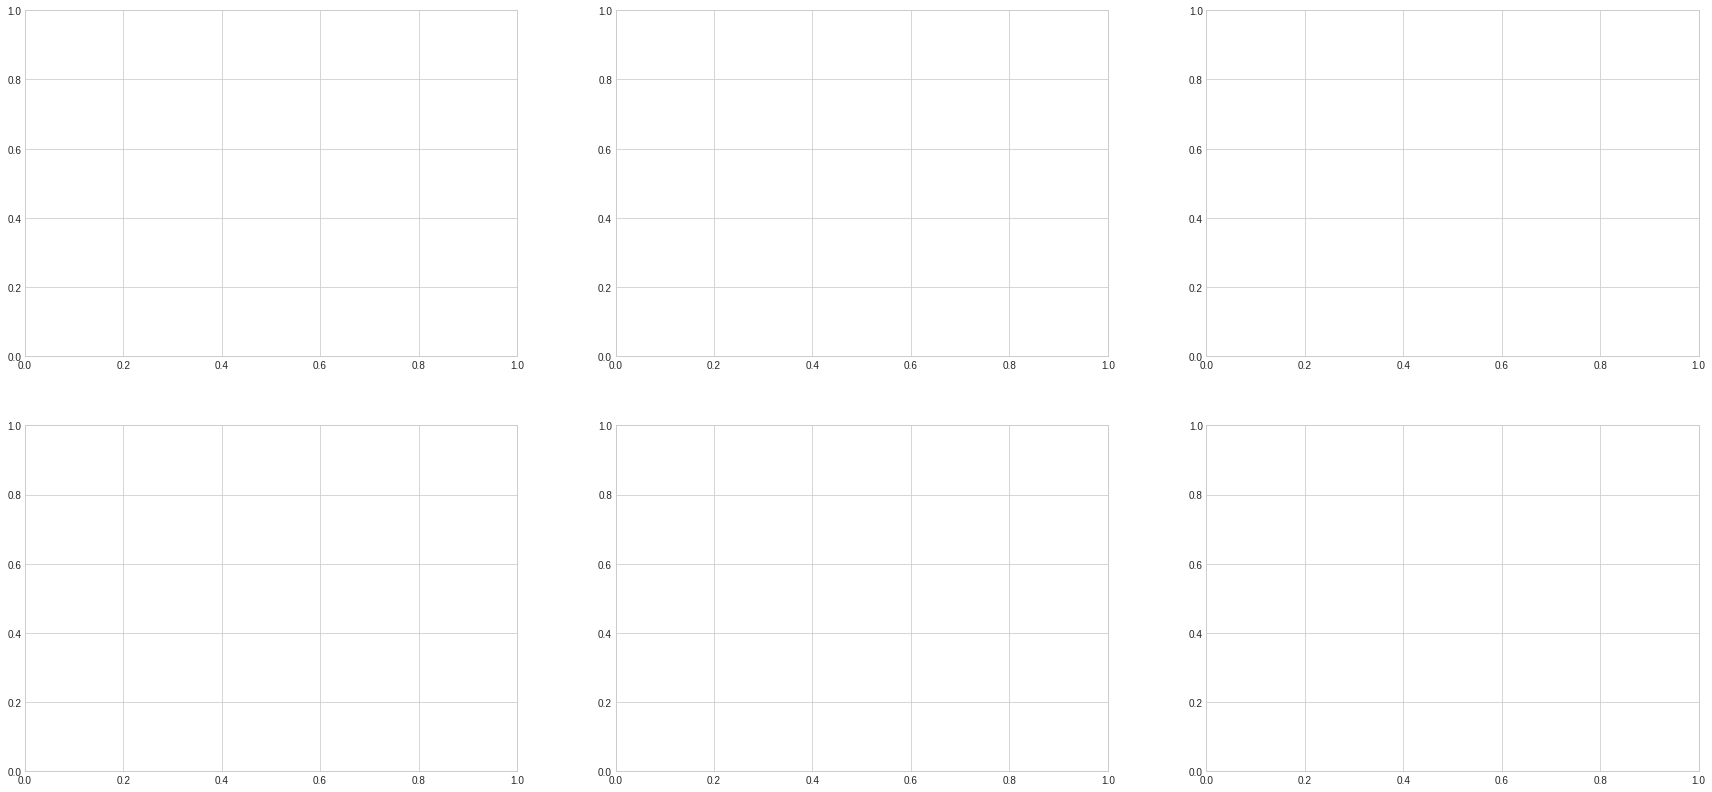

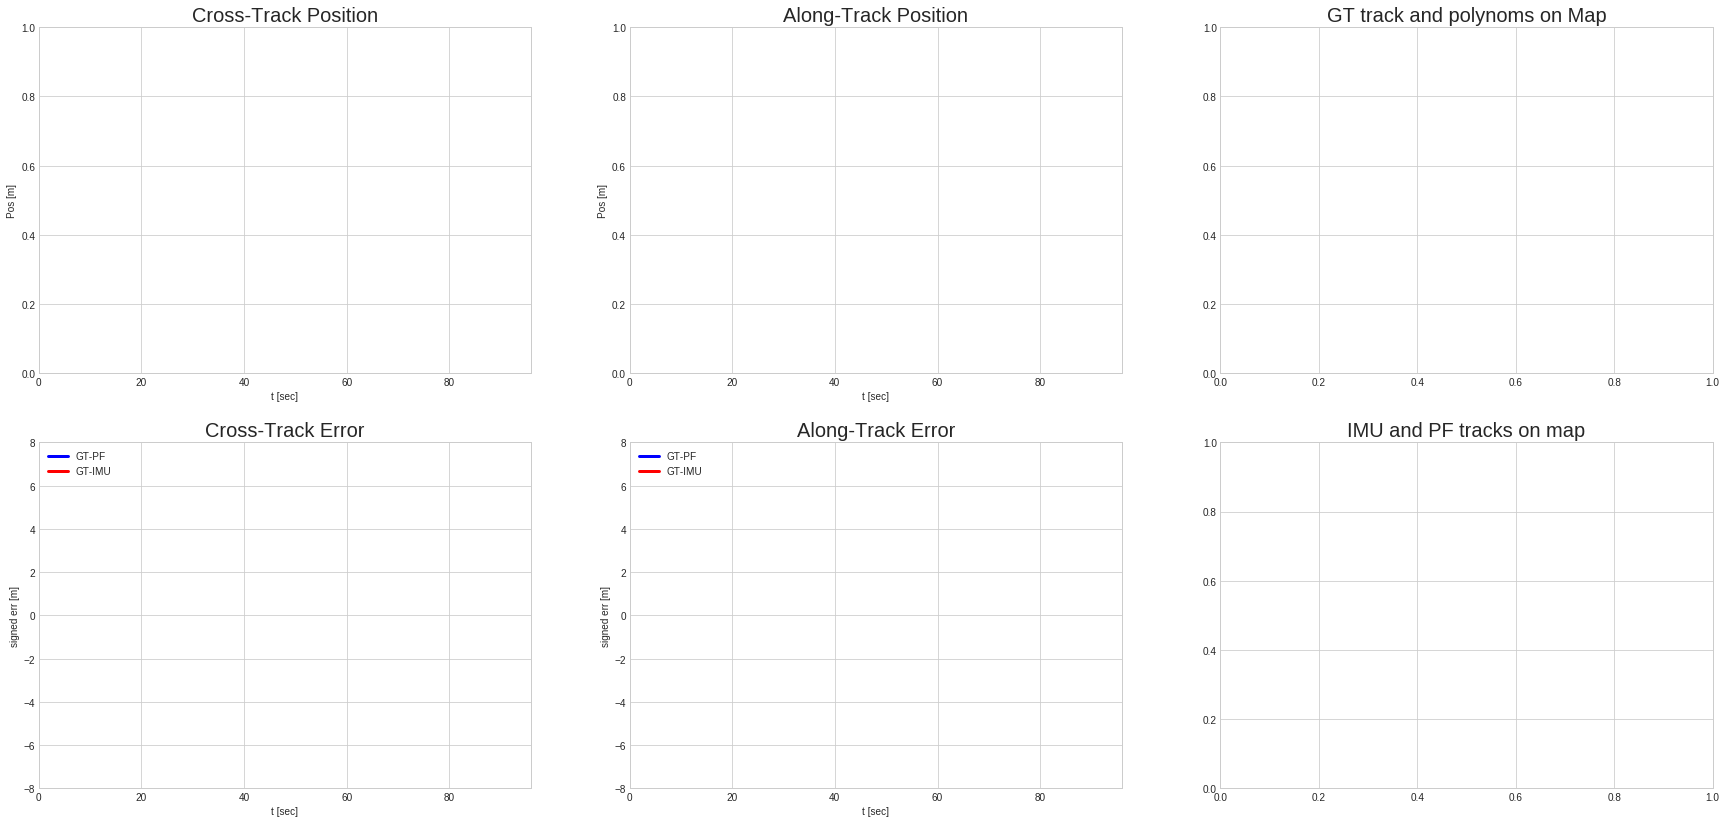

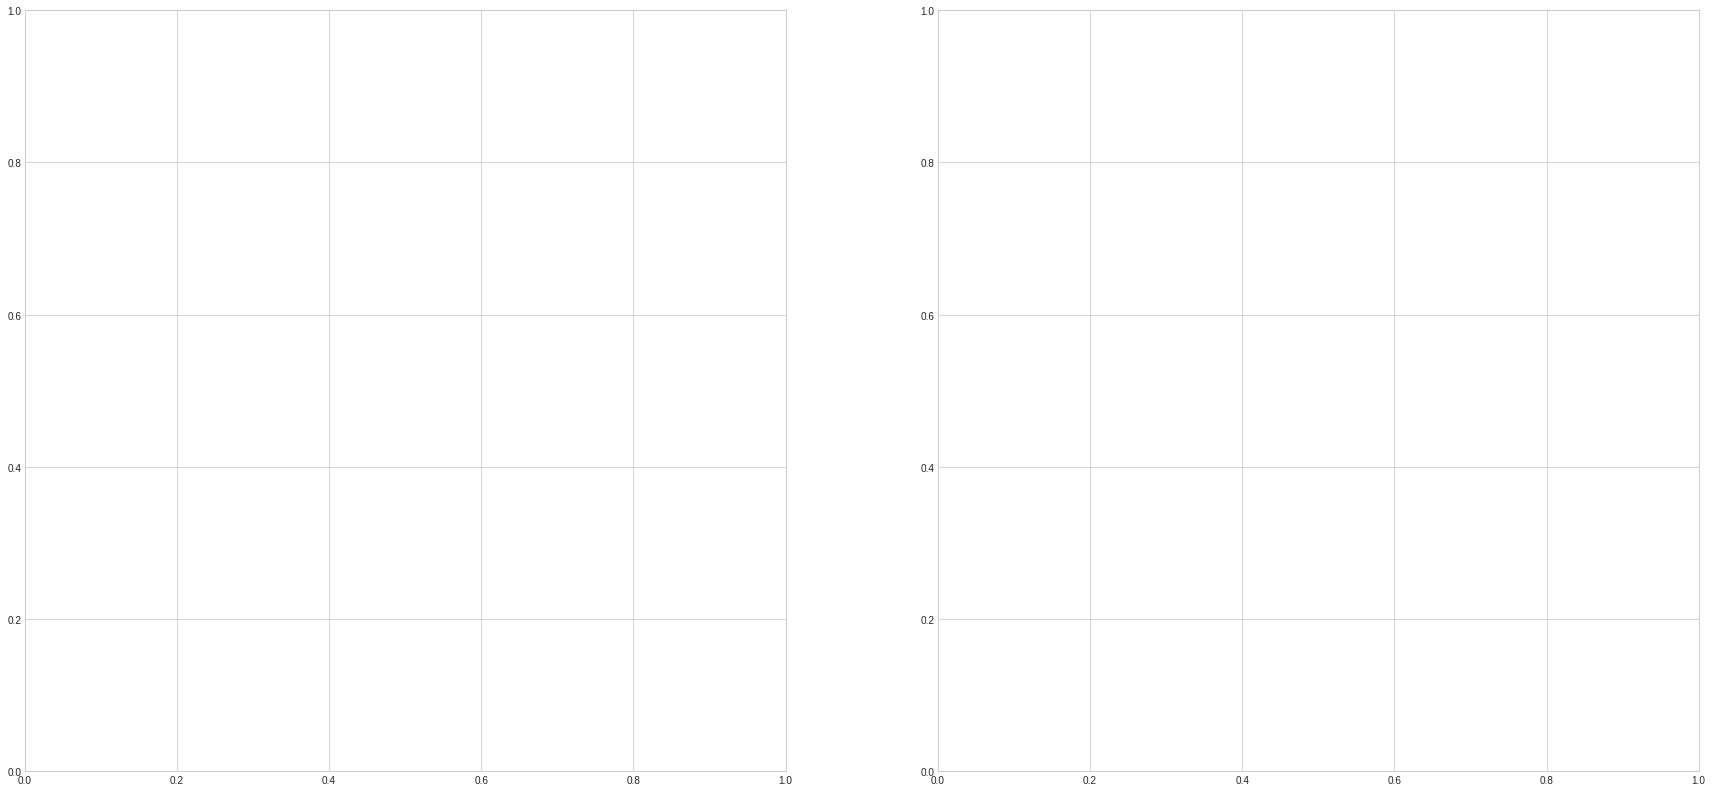

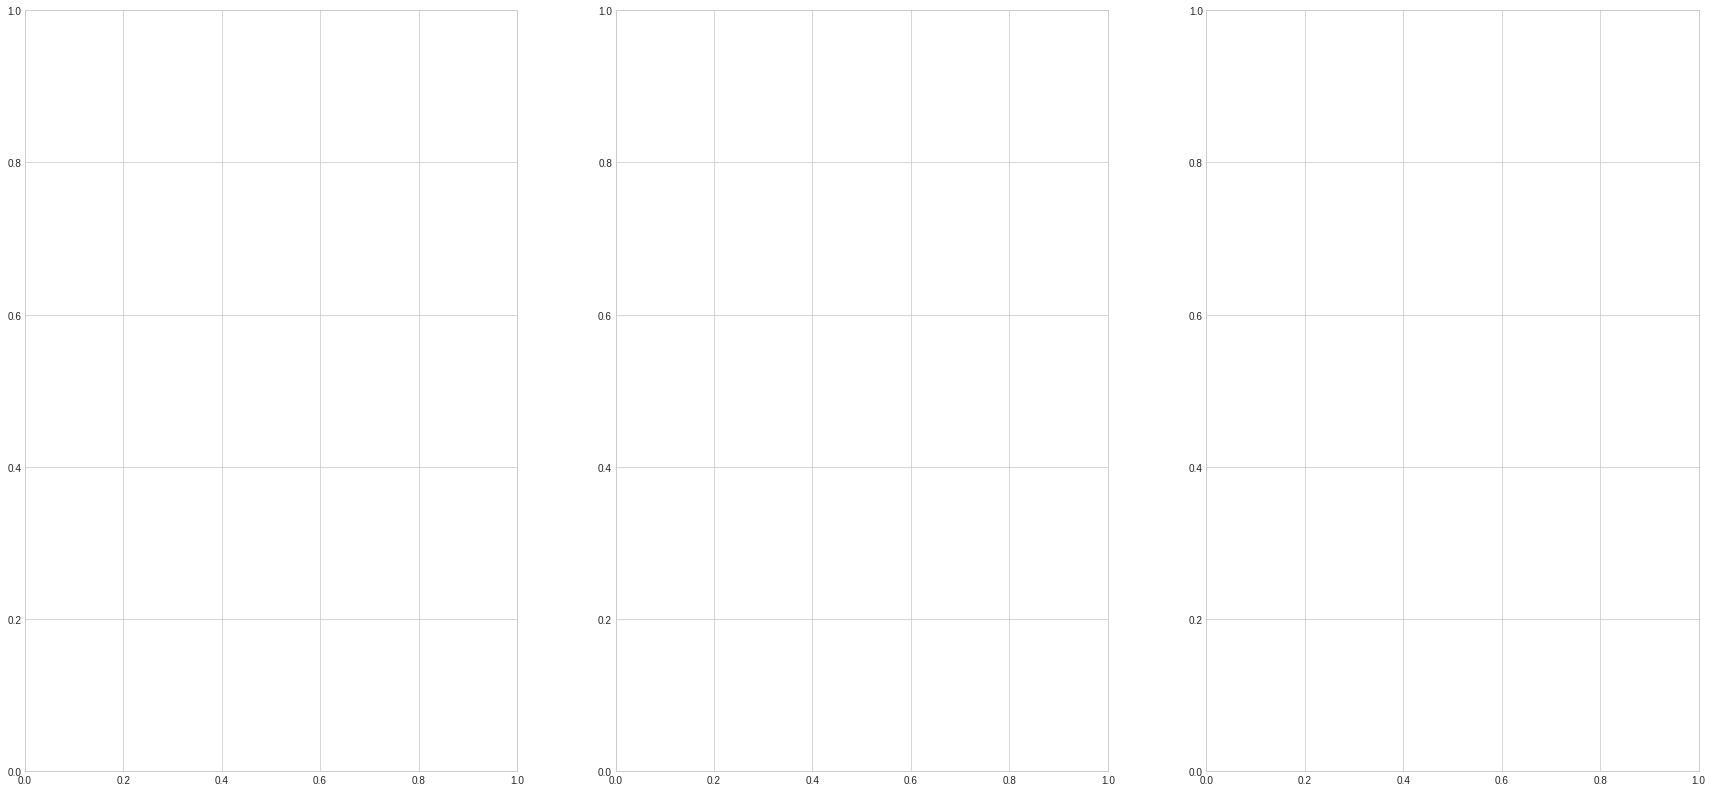

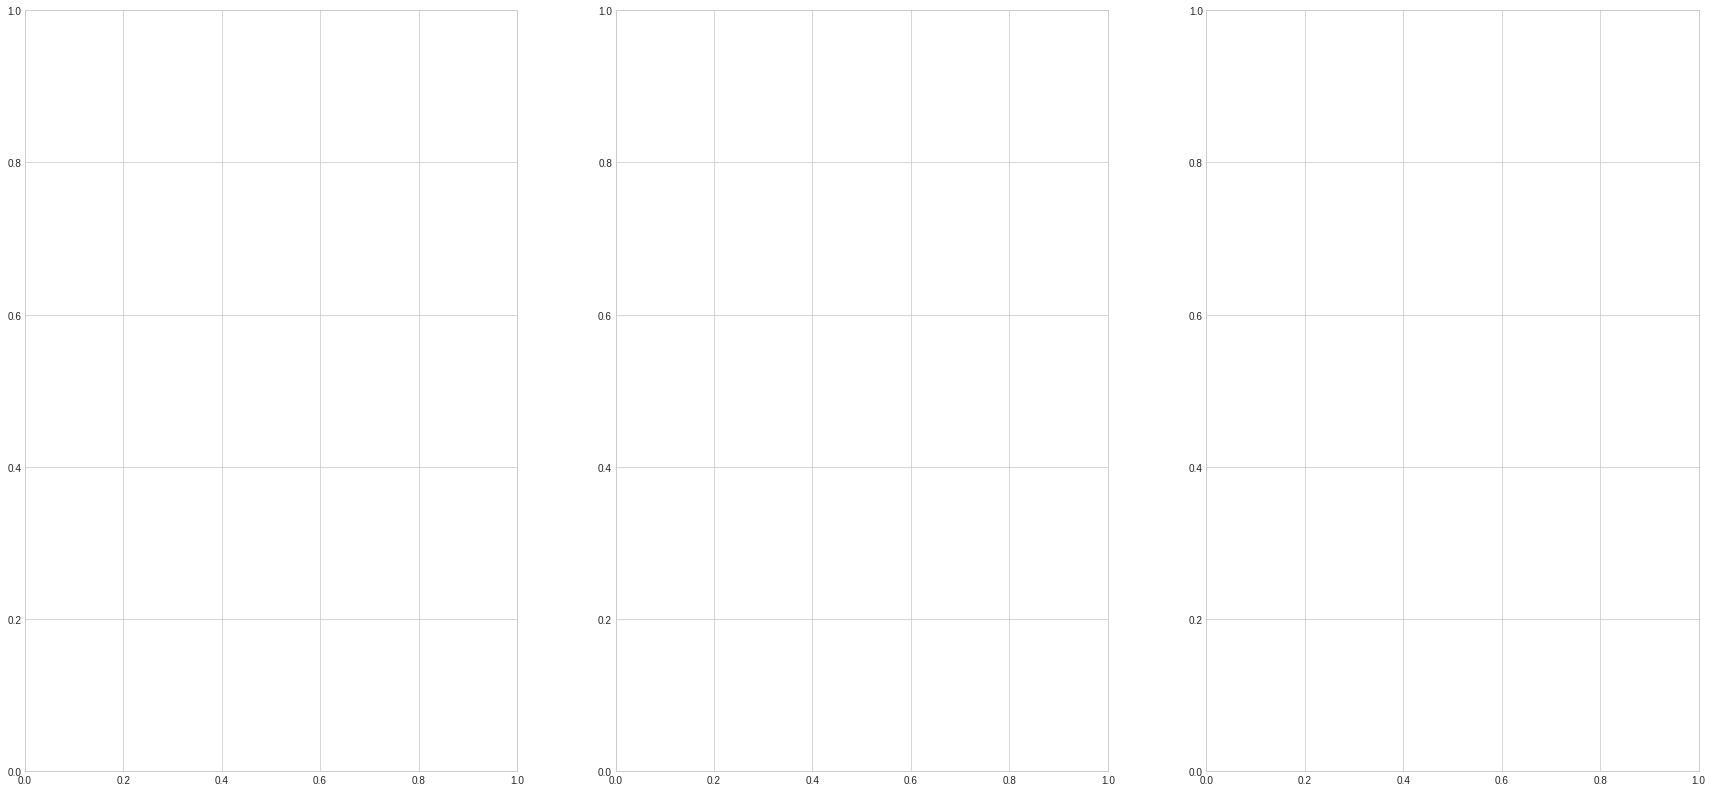

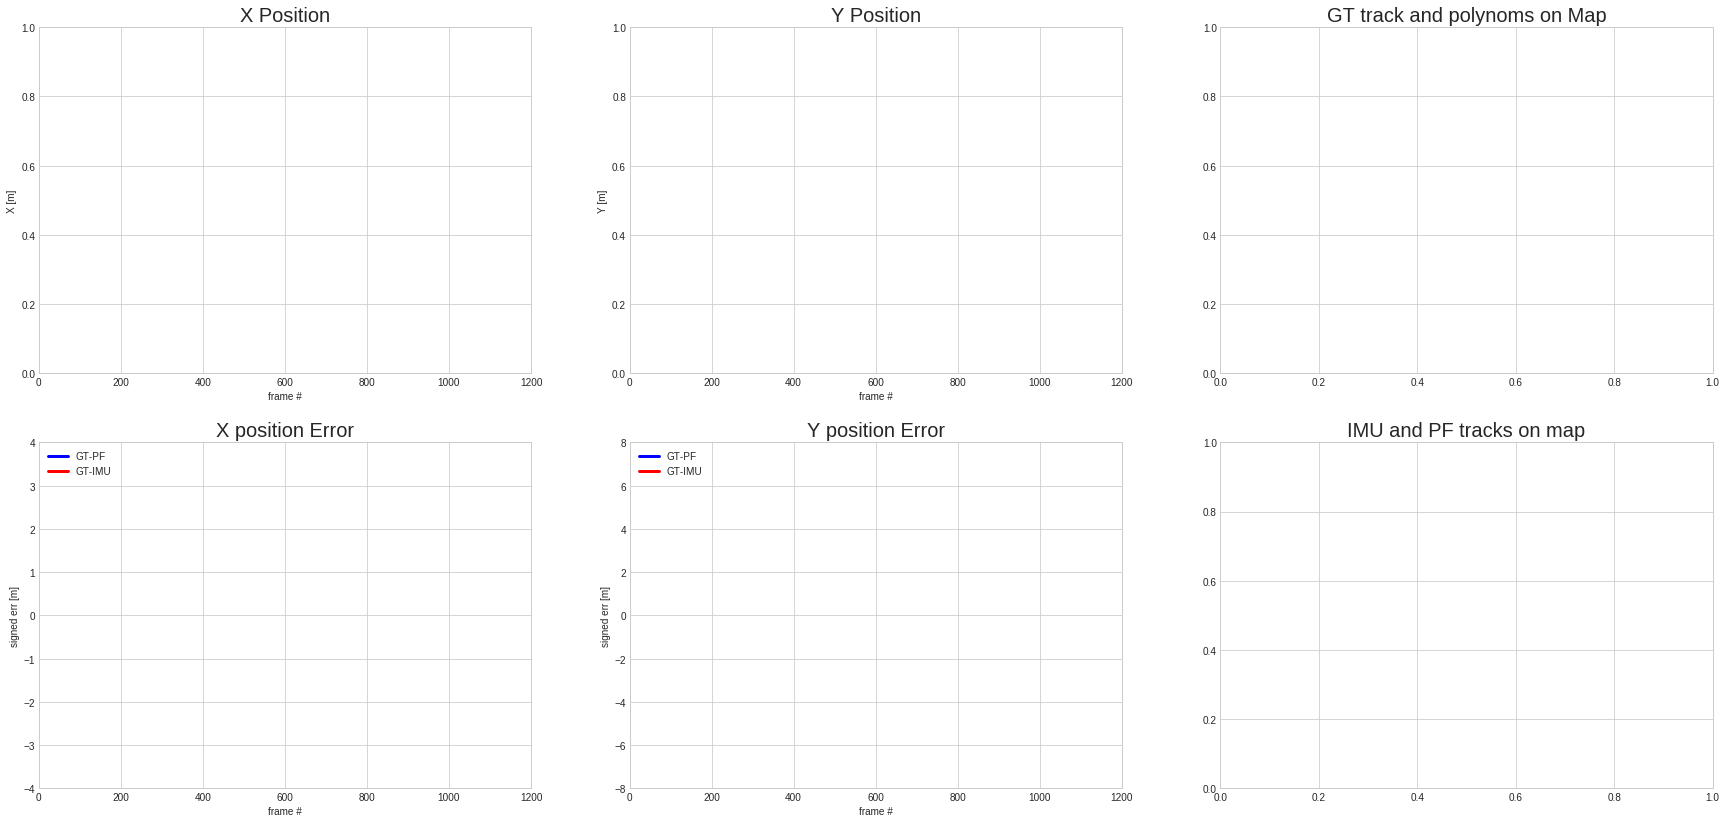

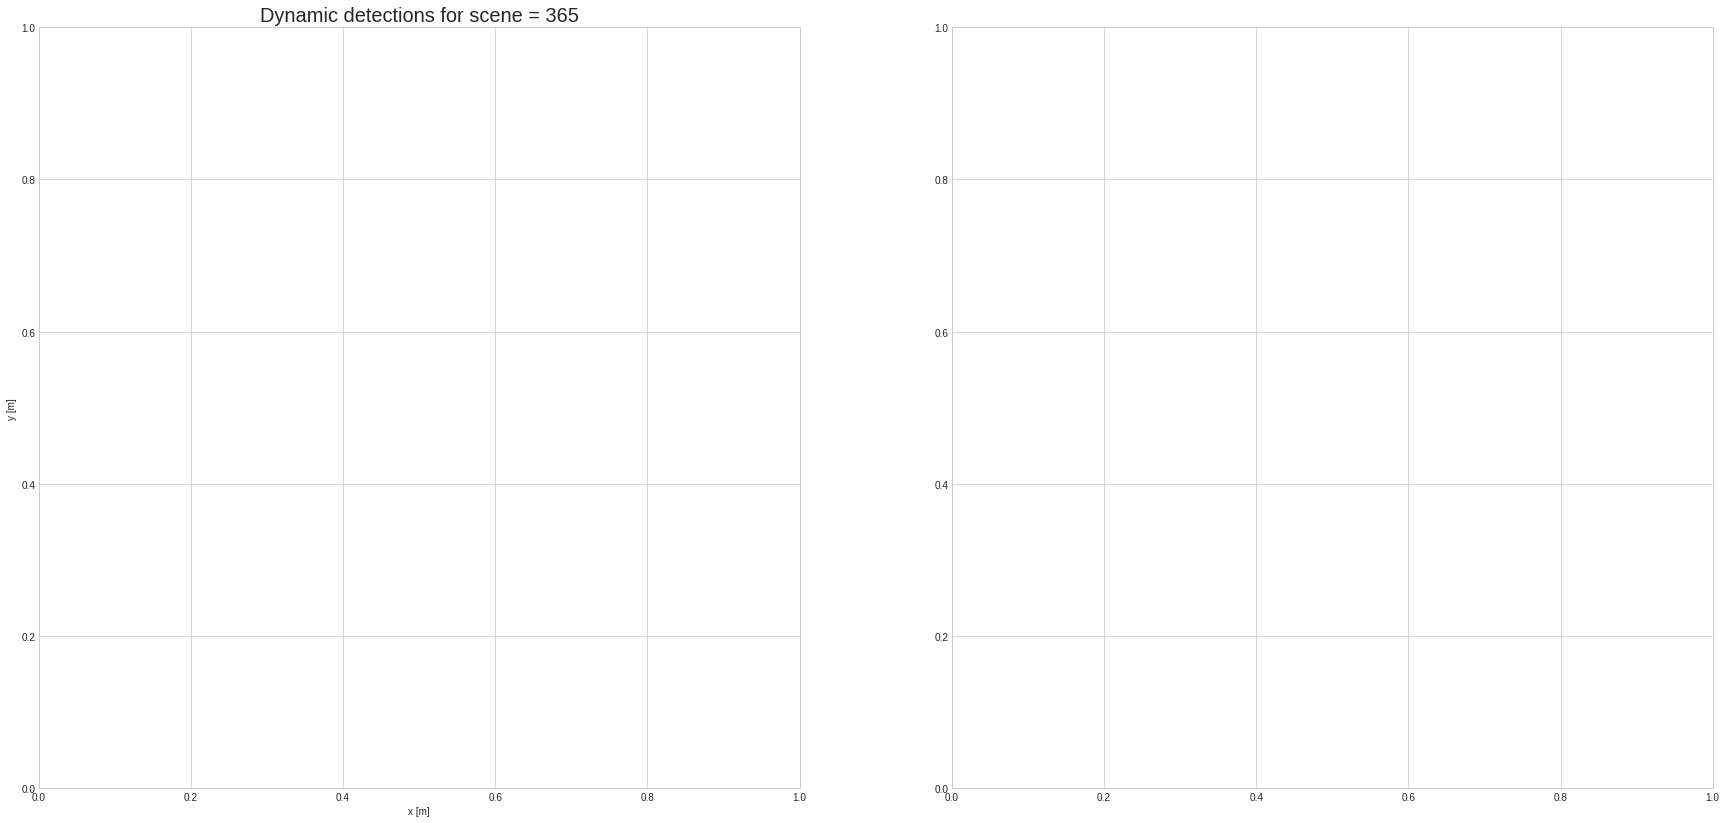

In [4]:
scene = 365 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)
sim.run(start=0, N=10, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

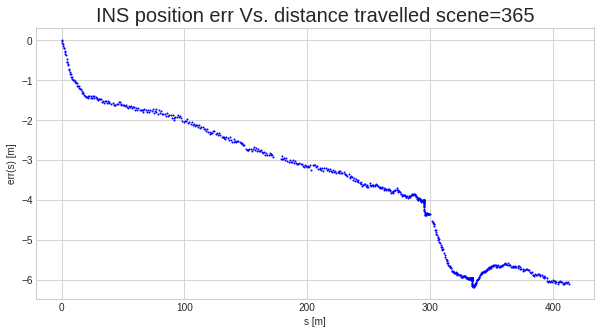

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


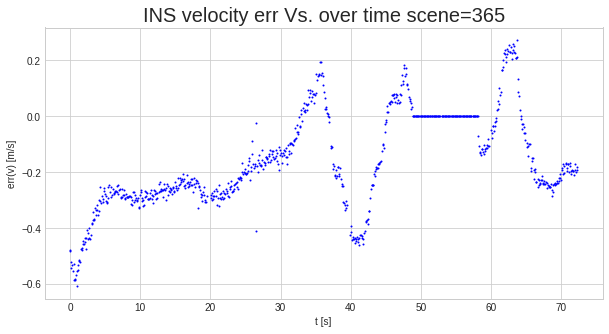

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [144]:
mapa = sim.dataset.getMap()


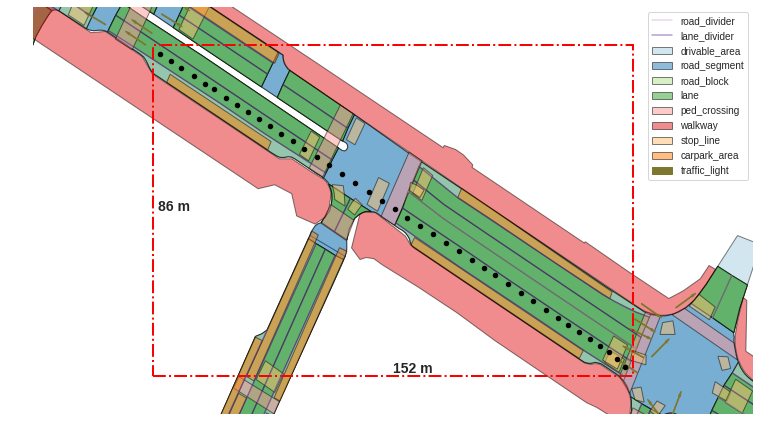

In [148]:
ego_poses = mapa.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[692]['token']], verbose=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_imu_rot = Quaternion(rot_imu[ridx,1])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


history []


/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

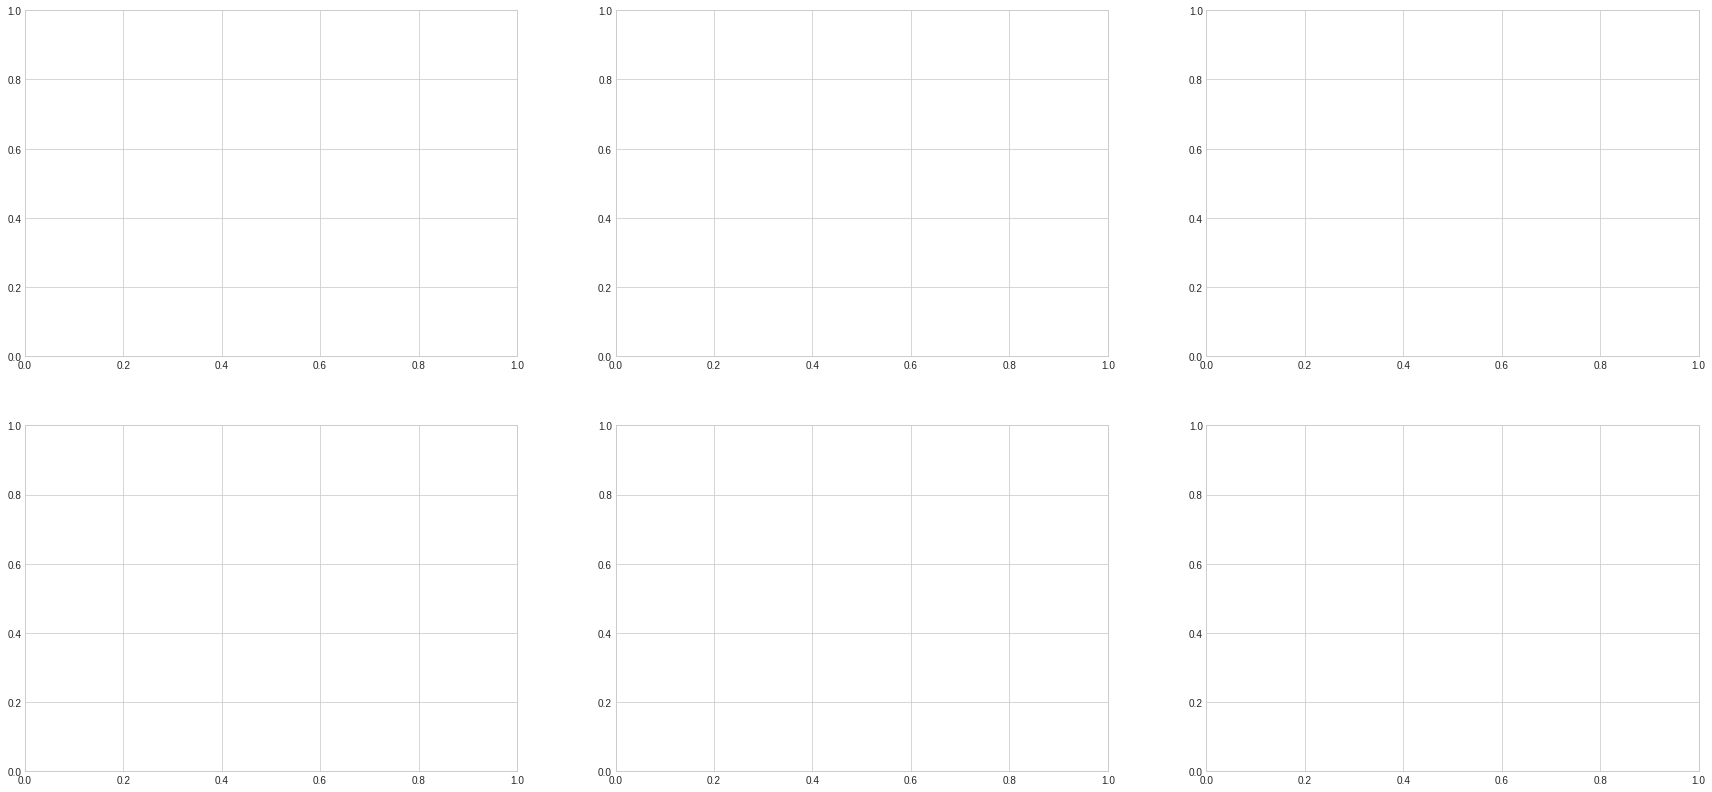

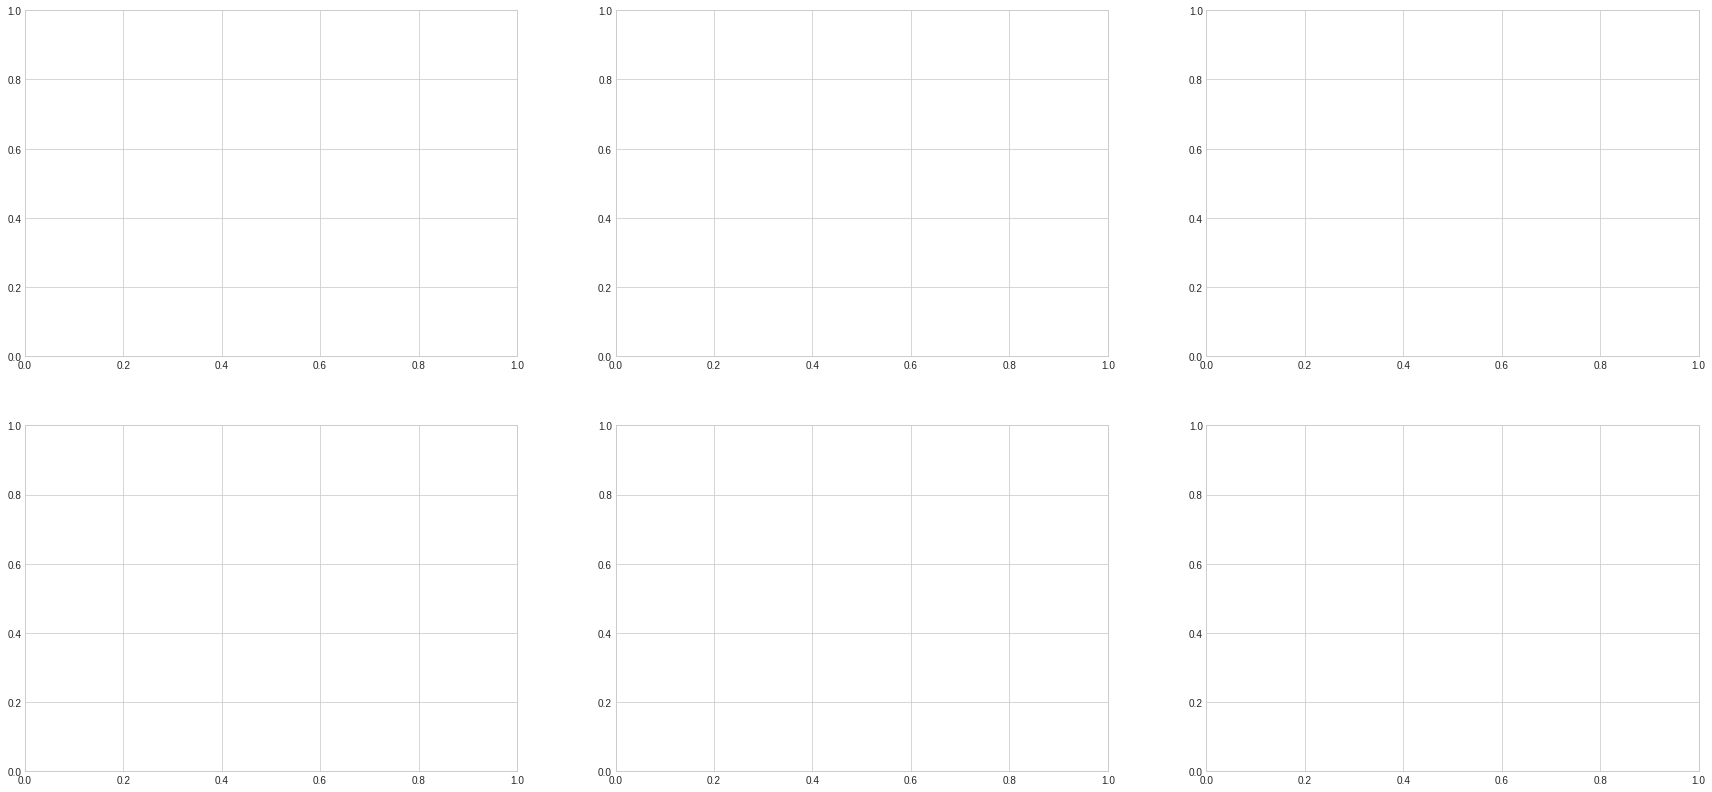

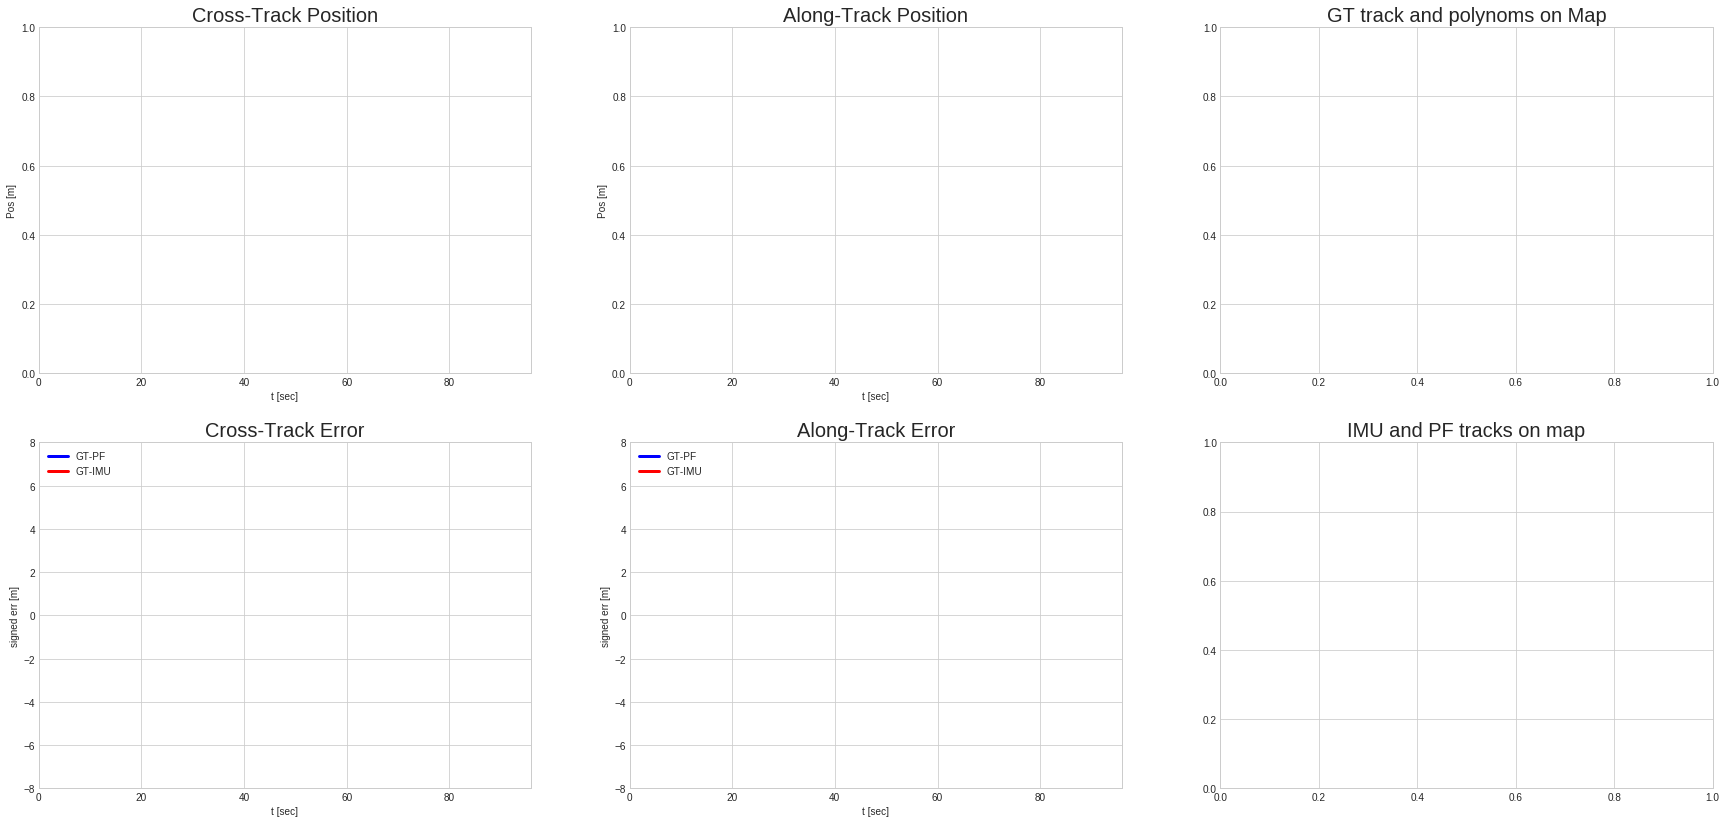

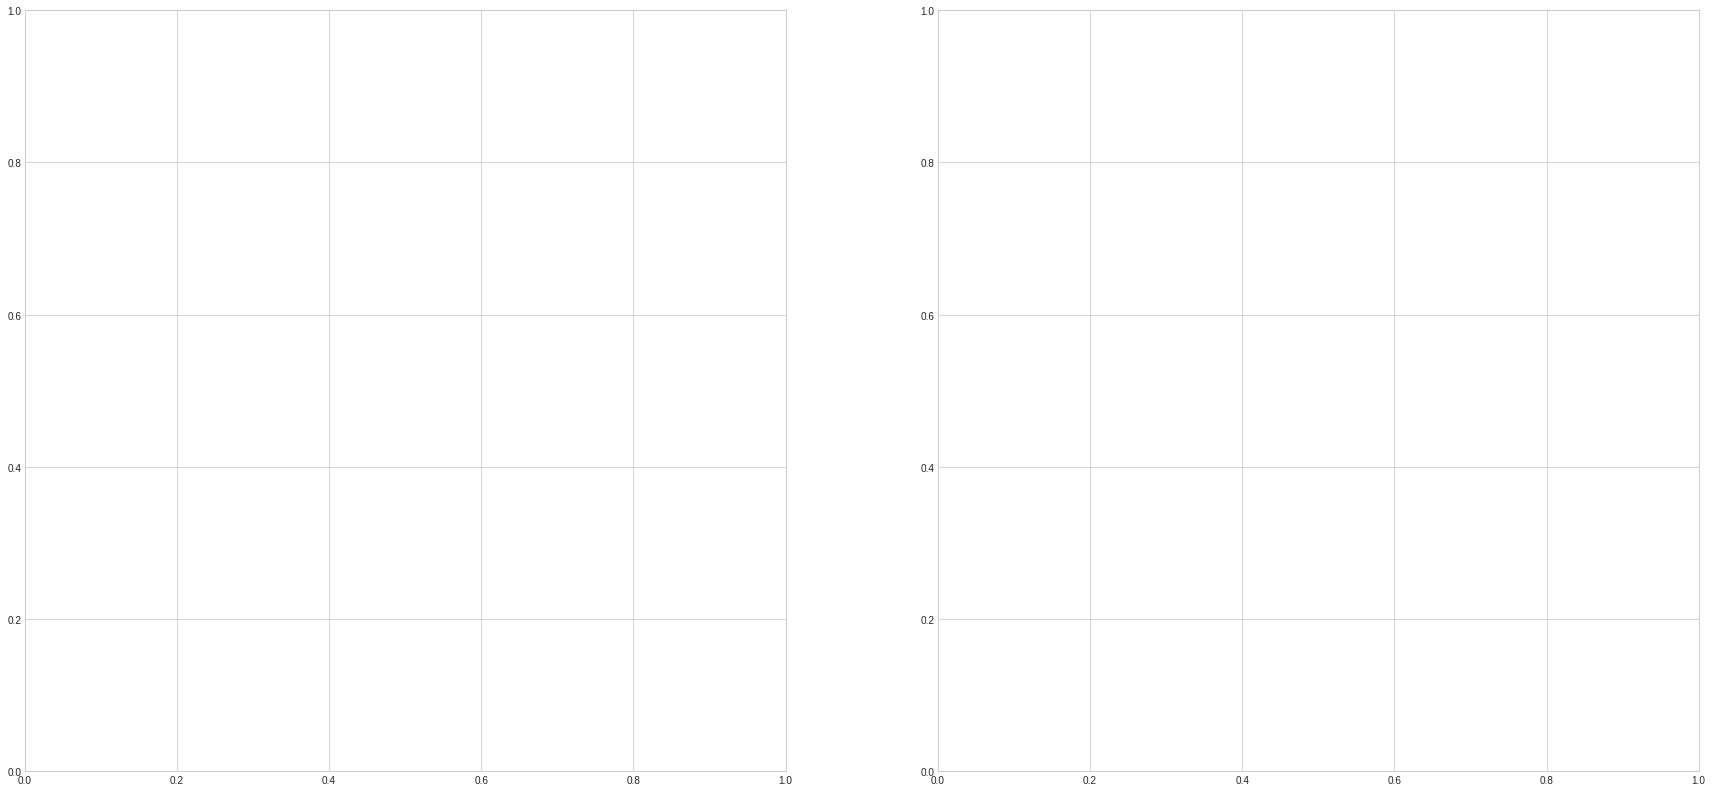

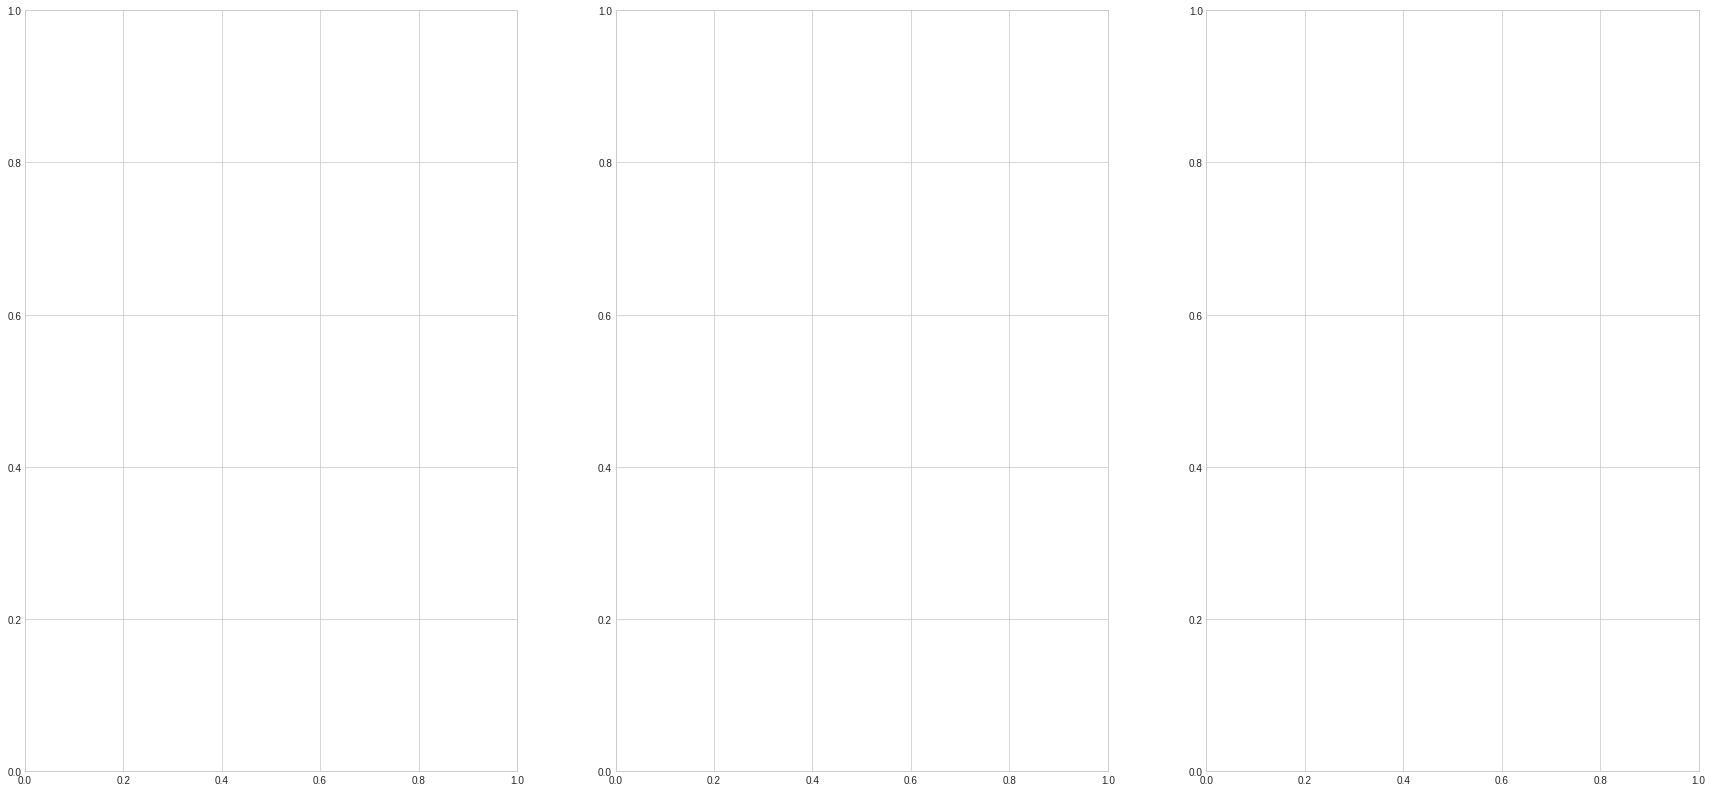

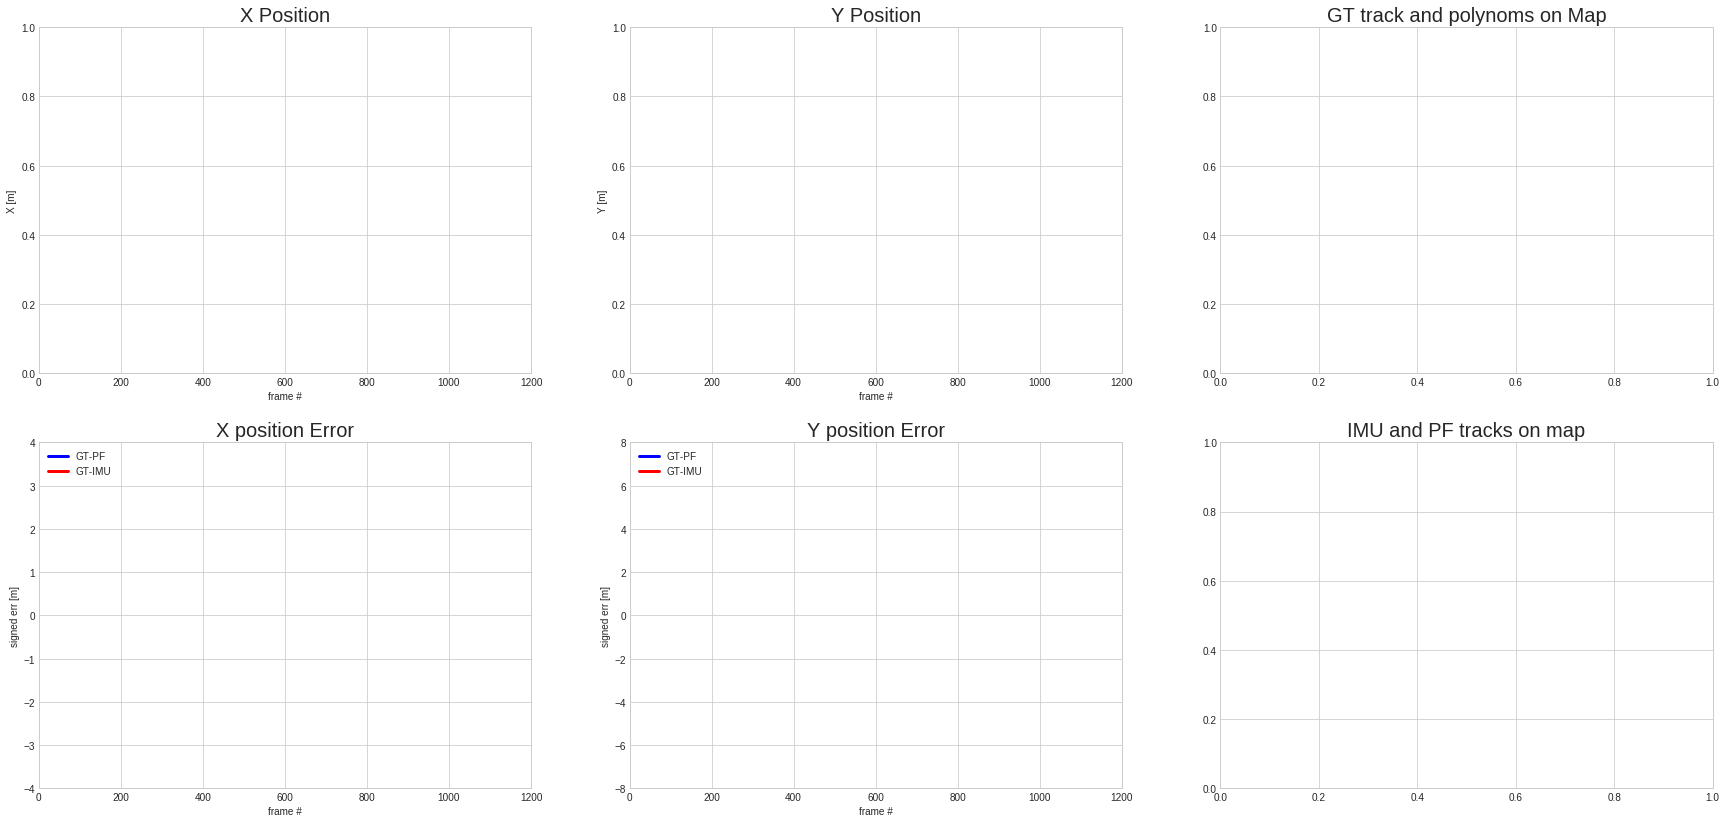

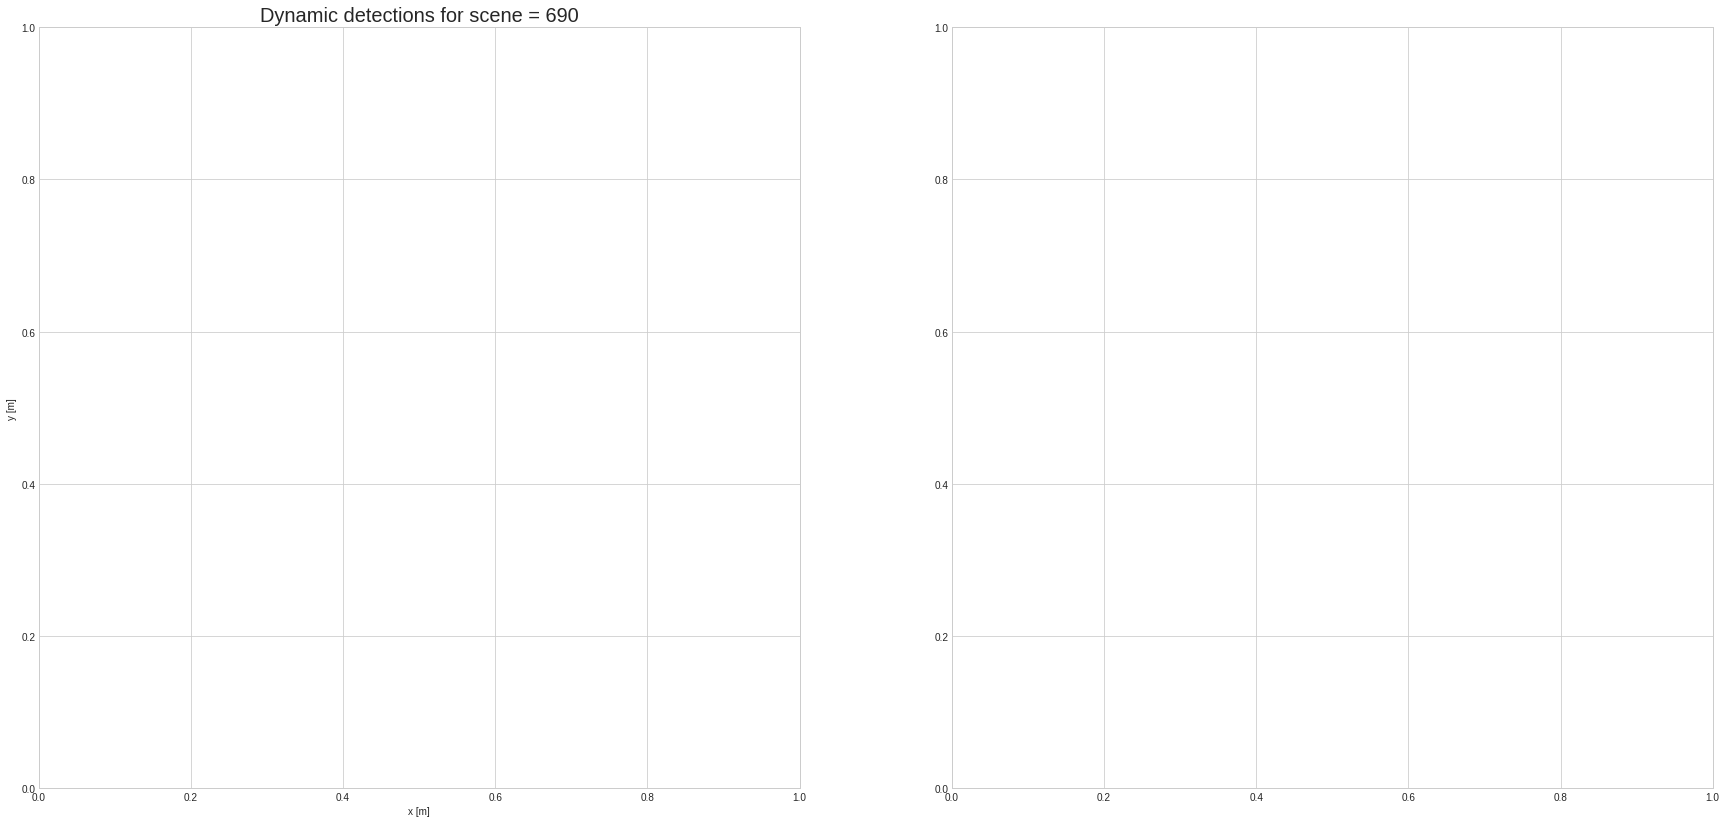

In [274]:
start_frame=0
n_frames = 15
ego_path = sim.dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
dbscan_clustering = ClassicDBSCAN()
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)

print("history",history)
for t in range(start_frame,n_frames):
    _, _, _, pc, video_data, _ = sim.dataset.getData(t,GT=False)
    ts, heading, ego_speed = video_data["timestamp"], np.deg2rad(video_data["heading"]-90), video_data["veh_speed"]
    print("t", t)
    Z, C = dbscan_clustering.run(pc=pc, ego=ego_path[t], heading=np.deg2rad(heading))
    print("C",C)
    tracker.run(Z, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)

In [275]:
def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if 1:#trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 5:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)
            
def drawClusters(ax, cluster, x_offset=0, y_offset=0):
        for c in C:
            print(c)
            x_com = c[0]
            y_com = c[1]
            print("scatter x_com", x_com, y_com)
            ax.scatter(x_com, y_com, s=100, color='green')

lane_record [{'start_pose': [1177.7862727154206, 1672.4999821898566, -0.5482126305436211], 'end_pose': [1198.753070199328, 1659.288089910761, -0.5478653376415797], 'shape': 'RSL', 'radius': 434.9672740042469, 'segment_length': [12.303630098631363, 0.024782725978953556, 12.454691145513522]}]
min_dist = 104.47598166395187
abs_vel =[5.90431763]
[1138.92071731 1576.08262102    2.75          0.        ]
scatter x_com 1138.9207173121658 1576.082621016088


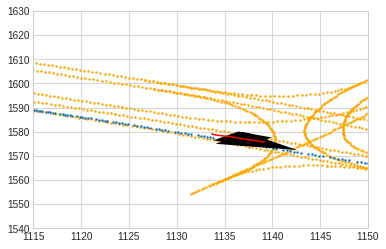

In [276]:
from nuscenes.map_expansion.map_api import NuScenesMap
import nuscenes.map_expansion.arcline_path_utils as path_utils
import numpy as np
import matplotlib.pyplot as plt

ax = plt.gca()
ax.clear()

n = 0
ego_path = sim.dataset.getEgoPath()
lane_ids = mapa.get_records_in_radius(ego_path[n,0], ego_path[n,1], 80, ['lane', 'lane_connector'])
nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']
for lane_token in nearby_lanes:
    lane_record = mapa.get_arcline_path(lane_token)
    poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
    poses = np.array(poses)
    ax.scatter(poses[:,0], poses[:,1],color='orange',s=2)
#lane_token = mapa.get_closest_lane(ego_path[n,0], ego_path[n,1], radius=2)
#fig, ax = mapa.render_layers(['lane'],tokens=lane_token)
    #lane_path = mapa.arcline_path_3.get(lane_token, [])

    #resolution_meters = 0.5
    #discretized = np.array(path_utils.discretize_lane(lane_path, resolution_meters))
#fig, ax = mapa.render_layers(['lane'])


#ax.plot(discretized[:,0], discretized[:,1], 's', color='orange')
ax.scatter(ego_path[:,0], ego_path[:,1],s=2)

ax.set_xlim([1115, 1150])
ax.set_ylim([1540, 1630])

np.min(np.linalg.norm(ego_path[n,:]-poses))
#lane_record = mapa.get_arcline_path(lane_token)
print("lane_record", lane_record)
#poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
#poses = np.array(poses)

min_dist = np.min(np.linalg.norm(ego_path[n,:2]-poses[:,0:2],axis=1))
print(f"min_dist = {min_dist}")
#print("poses",poses)
ax.scatter(poses[:,0], poses[:,1],s=2)

tracks = tracker.getHistory()
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2)
    
drawClusters(ax, C)
#ax.axis('equal')
#plt.show()

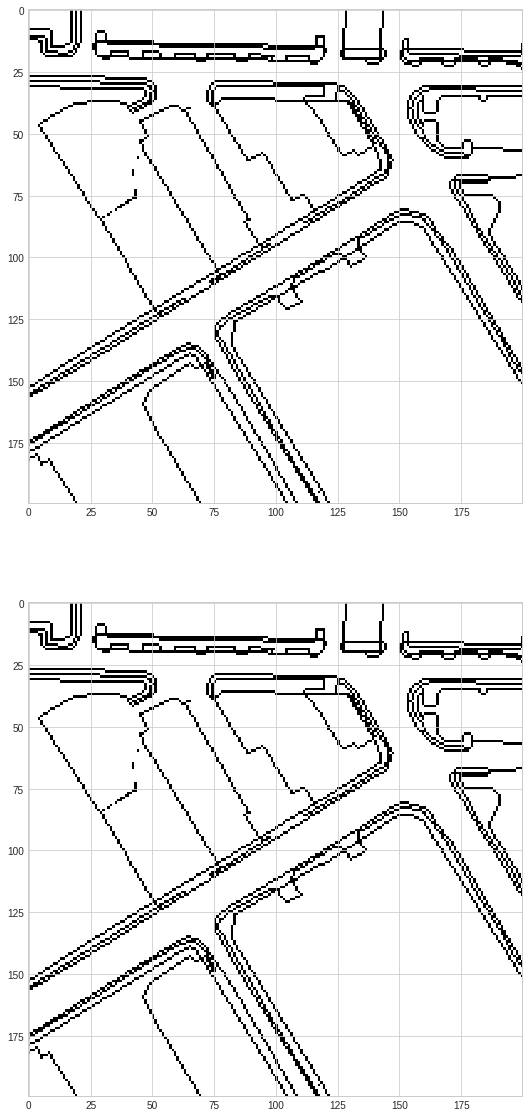

In [71]:
from map_utils import *

#sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=690, Nmax=1200, video_list=video_list)


fig, ax = plt.subplots(2,figsize=(10,20))
mapa = sim.dataset.getMap()
ego_path = sim.dataset.getEgoPath()
orig = getCombinedMap(mapa,ego_path[300,:],smooth=False)#[80:120,100:150]
smoothed = getCombinedMap(mapa,ego_path[300,:],smooth=True)#[80:120,100:150]
ax[0].imshow(orig)
ax[1].imshow(smoothed)
#plt.imsave('690.png', binary_map)

In [705]:
from scipy.interpolate import splrep, splev

def getLineIndication(pos, N=50, thr=0.05):
        x = pos[-N:,0]
        y = pos[-N:,1]

        fit, cov = np.polyfit(x, y, 1, cov=True)
        print("cov",cov,"fit",fit)
        if np.sqrt(cov[0,0]) < thr:
            return True

        return False

def computeIMUAngleBias(imuPos, pfPose, N=50):
    if imuPos.shape[0] >= 5 and getLineIndication(imuPos, N=N):
        ax = imuPos[-N:,0] - imuPos[0,0]
        ay = imuPos[-N:,1] - imuPos[0,1]
        bx = pfPose[-N:,0] - pfPose[0,0]
        by = pfPose[-N:,1] - pfPose[0,1]
        angle_bias = np.arctan2(ax*by - ay*bx, ax*bx + ay*by)
        return angle_bias

    return None

In [709]:
pf_pos = np.array([[0,0],[100,-50],[200,-100],[300,-150],[400,-200]])
imu_pos = np.array([[0,0],[100,-51],[200,-10],[300,-13],[400,-204]])
print(imu_pos.shape)
print(computeIMUAngleBias(imu_pos, pf_pos)[-1])

(5, 2)
[  0 100 200 300 400] [   0  -51  -10  -13 -204]
cov [[ 5.11306667e-02 -1.02261333e+01]
 [-1.02261333e+01  3.06784000e+03]] fit [-0.37 18.4 ]


TypeError: 'NoneType' object is not subscriptable

In [665]:
math.atan2(4,4)

0.7853981633974483

In [ ]:
-0.37 * 400